In [239]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.figure_factory as ff
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score,roc_auc_score
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler, NeighbourhoodCleaningRule
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# importa os Arquivos da URL e os salvam na pasta src
def data_import_save(url =  "https://raw.githubusercontent.com/alura-cursos/ML_Classificacao_por_tras_dos_panos/main/Dados/Customer-Churn.csv", 
                         savepath = '..\\src\\data\\churn_detection_raw.csv'):
    df_temp = pd.read_csv(url)
    df_temp.to_csv(savepath)
    return df_temp

# uma fiunção que retorna os valores unicos e a quantidade de cada coluna 
def info_dados(df):
    columns = df.columns
    values = []
    
    for column in columns:
        tipo_dado = str(df[column].dtype)
        unico_dado = df[column].unique().shape[0]
        values.append([column,tipo_dado,unico_dado])
#         print(f'Column: {column}')
#         print(df[column].unique(), f'Shape: {df[column].unique().shape[0]}', df[column].dtype)
    return values
        
# procura coluna com numeros inteiros que tenham apenas zeros e uns e os transforma em uint8
def zeroum_to_uint8(df):
    for column in df.columns:
        if (str(df[column].dtype).startswith('int') or str(df[column].dtype).startswith('float')) and df[column].unique().sum() == 1:
            df[column] = df[column].astype('uint8')

# aplica o get dummies em cada coluna separadamente, retorna uma data frame sem os ultimos valores dos dummies            
def get_dummies_drop_last(df):
    columns = df.columns
    df_aux = pd.DataFrame()
    for column in columns:
        df_tmp = pd.get_dummies(df[[column]])
        if df_tmp.columns.shape[0]>=2:
            df_aux = pd.concat([df_aux,df_tmp.drop(df_tmp.columns[-1], axis=1)],axis=1)
        else:
            df_aux = pd.concat([df_aux,df_tmp], axis=1)
    return df_aux        

## Análise Exploratória Dos Dados Originais

In [232]:
# retorna os primeiros valores da dataframe original
df_raw = data_import_save()
df_raw.head()

,Maior65Anos,Conjuge,Dependentes,MesesDeContrato,TelefoneFixo,VariasLinhasTelefonicas,ServicoDeInternet,SegurancaOnline,BackupOnline,SeguroNoDispositivo,SuporteTecnico,TVaCabo,StreamingDeFilmes,TipoDeContrato,PagamentoOnline,FormaDePagamento,ContaMensal,Churn
0,0,Sim,Nao,1,Nao,SemServicoTelefonico,DSL,Nao,Sim,Nao,Nao,Nao,Nao,Mensalmente,Sim,ChequeDigital,29.85,Nao
1,0,Nao,Nao,34,Sim,Nao,DSL,Sim,Nao,Sim,Nao,Nao,Nao,UmAno,Nao,ChequePapel,56.95,Nao
2,0,Nao,Nao,2,Sim,Nao,DSL,Sim,Sim,Nao,Nao,Nao,Nao,Mensalmente,Sim,ChequePapel,53.85,Sim
3,0,Nao,Nao,45,Nao,SemServicoTelefonico,DSL,Sim,Nao,Sim,Sim,Nao,Nao,UmAno,Nao,DebitoEmConta,42.30,Nao
4,0,Nao,Nao,2,Sim,Nao,FibraOptica,Nao,Nao,Nao,Nao,Nao,Nao,Mensalmente,Sim,ChequeDigital,70.70,Sim


In [233]:
#retorna numero de linas e de colunas
df_raw.shape

(7043, 18)

In [255]:
# Avalia o tipo de dado de cada coluna da dataframe original
infodados = pd.DataFrame(info_dados(df_raw),columns=['Colunas','Tipo_Dado','Qtde_Unicos'])
infodados

,Colunas,Tipo_Dado,Qtde_Unicos
0,Maior65Anos,object,2
1,Conjuge,object,2
2,Dependentes,object,2
3,MesesDeContrato,int64,73
4,TelefoneFixo,object,2
5,VariasLinhasTelefonicas,object,3
6,ServicoDeInternet,object,3
7,SegurancaOnline,object,3
8,BackupOnline,object,3
9,SeguroNoDispositivo,object,3


In [254]:
df_raw['Maior65Anos'] = df_raw.Maior65Anos.astype(str)

In [235]:
total_de_nulos = df_raw.isna().sum().sum()
print(f'A quantidade total de nulos nesse banco de dados é: {total_de_nulos}')

A quantidade total de nulos nesse banco de dados é: 0


In [236]:
# Calcula o valor total perido pela empresa devido ao Churn de clientes
total_perdido = df_raw.groupby('Churn').sum().iloc[1][2]
print(f'O total perdido devido a saída de clientes é: R$ {total_perdido}')

O total perdido devido a saída de clientes é: R$ 139130.85


In [237]:
# retorna a descrição de todas as colunas com suas estatístiocas pertinentes
describ_ = df_raw.describe(include = "all")
describ_

,Maior65Anos,Conjuge,Dependentes,MesesDeContrato,TelefoneFixo,VariasLinhasTelefonicas,ServicoDeInternet,SegurancaOnline,BackupOnline,SeguroNoDispositivo,SuporteTecnico,TVaCabo,StreamingDeFilmes,TipoDeContrato,PagamentoOnline,FormaDePagamento,ContaMensal,Churn
count,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,2
top,NaN,Nao,Nao,NaN,Sim,Nao,FibraOptica,Nao,Nao,Nao,Nao,Nao,Nao,Mensalmente,Sim,ChequeDigital,NaN,Nao
freq,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,5174
mean,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


In [238]:
#transformando o tipo de contrato em MesesParaPagamento
uniques_tipo_contrato = ['Mensalmente', 'UmAno', 'DoisAnos']
list(df_raw.TipoDeContrato.unique())
df_raw['MesesParaPagamento'] = df_raw.TipoDeContrato.replace({'Mensalmente':1, 'UmAno':12, 'DoisAnos':24})
df_raw = df_raw.drop('TipoDeContrato',axis=1)
df_raw.loc[:100,:]

,Maior65Anos,Conjuge,Dependentes,MesesDeContrato,TelefoneFixo,VariasLinhasTelefonicas,ServicoDeInternet,SegurancaOnline,BackupOnline,SeguroNoDispositivo,SuporteTecnico,TVaCabo,StreamingDeFilmes,PagamentoOnline,FormaDePagamento,ContaMensal,Churn,MesesParaPagamento
0,0,Sim,Nao,1,Nao,SemServicoTelefonico,DSL,Nao,Sim,Nao,Nao,Nao,Nao,Sim,ChequeDigital,29.85,Nao,1
1,0,Nao,Nao,34,Sim,Nao,DSL,Sim,Nao,Sim,Nao,Nao,Nao,Nao,ChequePapel,56.95,Nao,12
2,0,Nao,Nao,2,Sim,Nao,DSL,Sim,Sim,Nao,Nao,Nao,Nao,Sim,ChequePapel,53.85,Sim,1
3,0,Nao,Nao,45,Nao,SemServicoTelefonico,DSL,Sim,Nao,Sim,Sim,Nao,Nao,Nao,DebitoEmConta,42.30,Nao,12
4,0,Nao,Nao,2,Sim,Nao,FibraOptica,Nao,Nao,Nao,Nao,Nao,Nao,Sim,ChequeDigital,70.70,Sim,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0,Sim,Sim,71,Sim,Sim,DSL,Sim,Sim,Nao,Sim,Nao,Nao,Sim,CartaoDeCredito,66.85,Nao,12
97,0,Nao,Nao,5,Sim,Nao,Nao,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,Nao,ChequePapel,21.05,Sim,1
98,0,Nao,Nao,52,Sim,Nao,Nao,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,Nao,DebitoEmConta,21.00,Nao,24
99,1,Sim,Nao,25,Sim,Nao,FibraOptica,Nao,Sim,Sim,Nao,Sim,Sim,Sim,ChequeDigital,98.50,Sim,1


In [305]:
fração_churn = df_raw.groupby('Churn').count().T/df_raw.groupby('Churn').count().T.iloc[0].sum()
fração_churn = df_aux.iloc[0][1]*100
print('Cerca de {:.2f}% de clientes deixaram a empresa.'.format(fração_churn))

Cerca de 26.54% de clientes deixaram a empresa.


In [311]:
df_raw.groupby('Churn').count().T.iloc[0][1]*0.78*60


87469.2

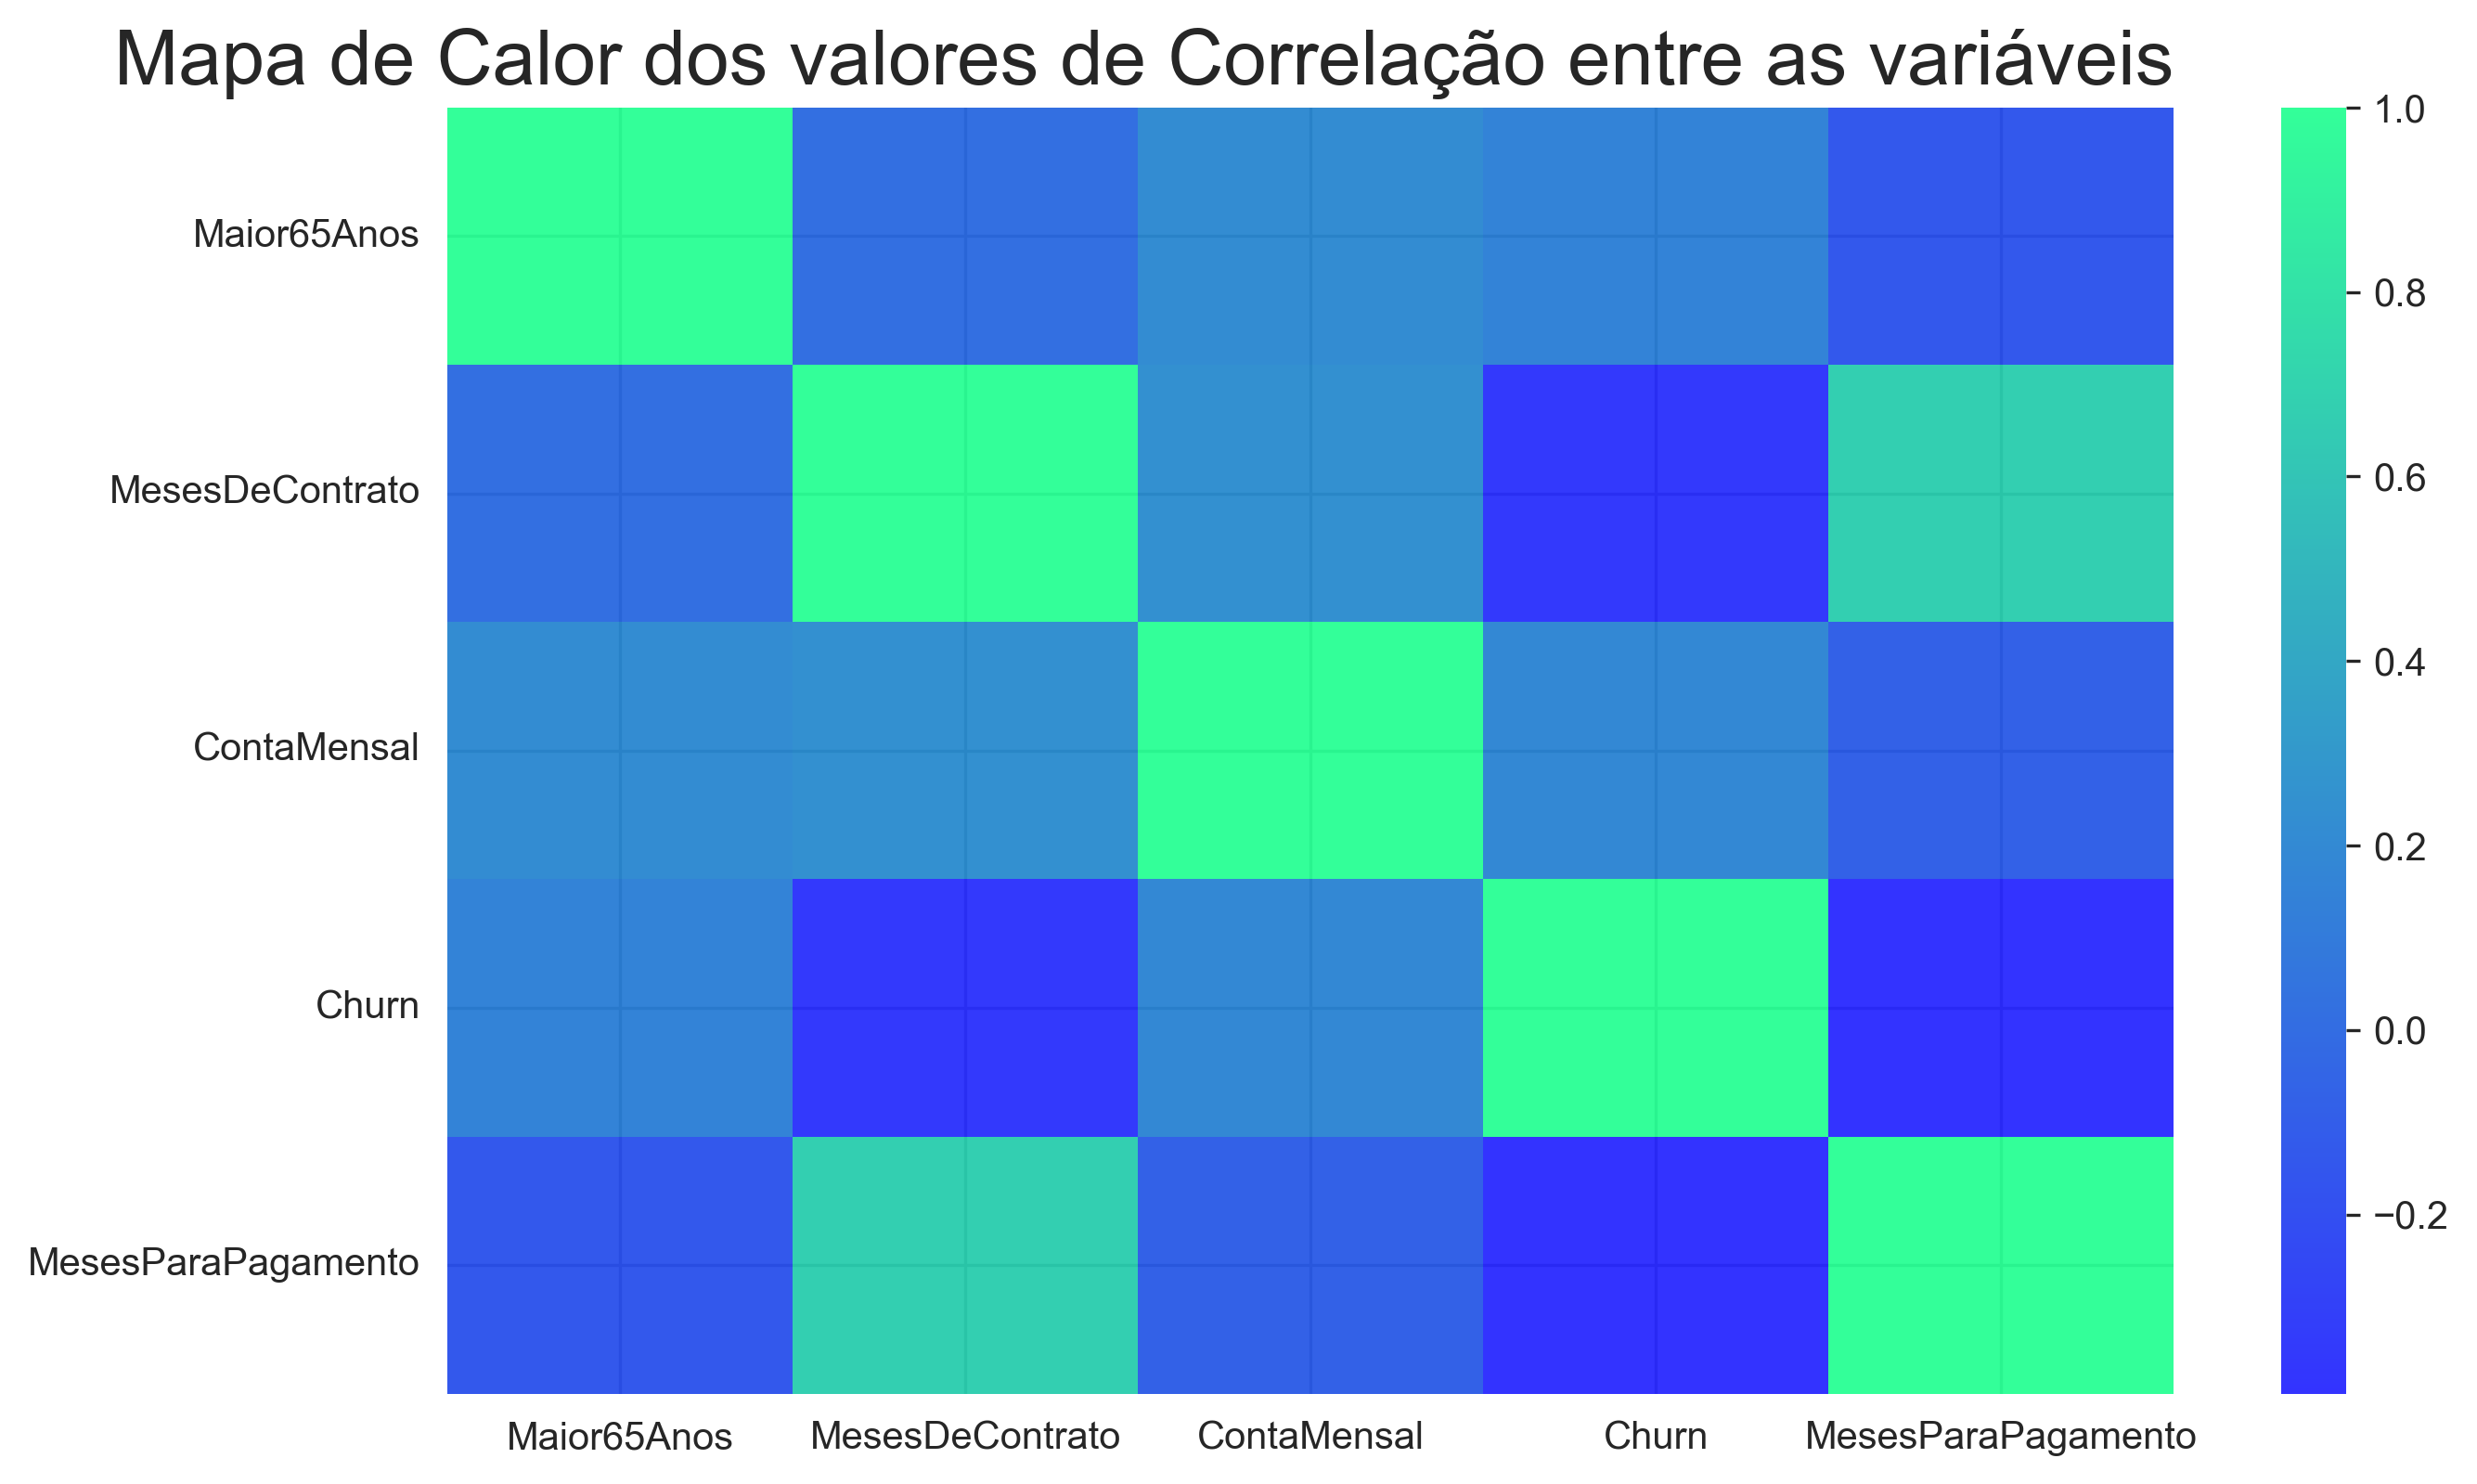

In [240]:
plt.figure(figsize=(10,6), dpi=300)
df_tmp = df_raw.copy()
df_tmp['Churn'] = df_tmp['Churn'].replace({'Sim':1,'Nao':0})
fig = sns.heatmap(df_tmp.corr(),xticklabels=1, yticklabels=1, cmap='winter', alpha=0.8 )
plt.title('Mapa de Calor dos valores de Correlação entre as variáveis',fontdict={'fontsize':20}, loc='right')
plt.savefig('../figs/heatmap_raw.png', bbox_inches='tight', dpi=300)
plt.show()

In [256]:
df_aux = df_raw.select_dtypes(include=["int64",'float64'])
df_aux['Churn'] = df_raw.Churn
df_aux.loc[:5]

,MesesDeContrato,ContaMensal,MesesParaPagamento,Churn
0,1,29.85,1,Nao
1,34,56.95,12,Nao
2,2,53.85,1,Sim
3,45,42.30,12,Nao
4,2,70.70,1,Sim
5,8,99.65,1,Sim


<Figure size 2800x2100 with 0 Axes>

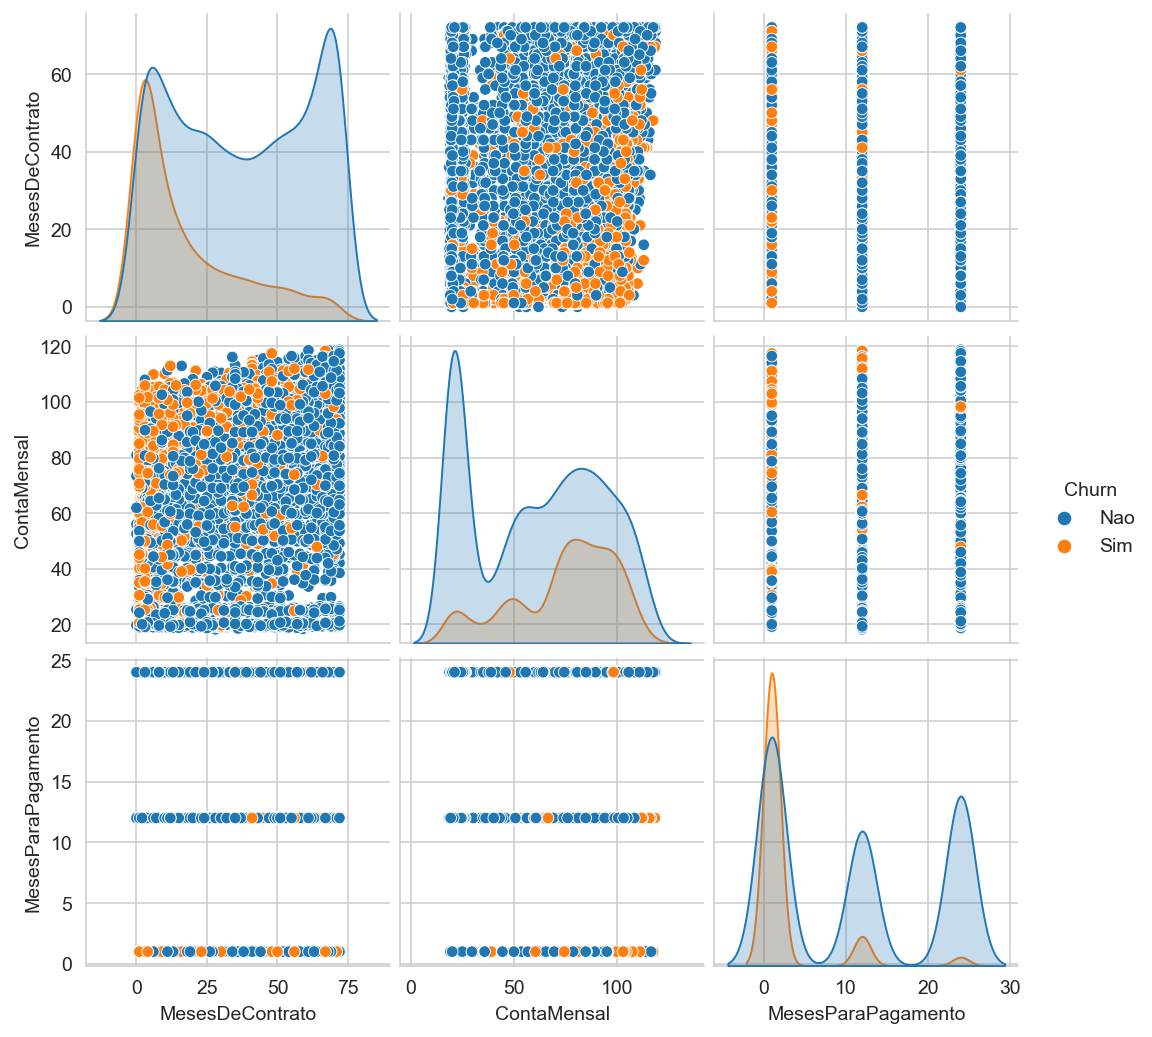

In [260]:
plt.figure(figsize=(20,15))
sns.pairplot(df_aux,hue = 'Churn')
plt.show()

## Análise Exploratória com Dummies

In [343]:
# transforma em dumies a dataframe original e retorna os primeiros valores
df = pd.get_dummies(df_raw,drop_first=True)
df.head()

,MesesDeContrato,ContaMensal,MesesParaPagamento,Maior65Anos_1,Conjuge_Sim,Dependentes_Sim,TelefoneFixo_Sim,VariasLinhasTelefonicas_SemServicoTelefonico,VariasLinhasTelefonicas_Sim,ServicoDeInternet_FibraOptica,...,SuporteTecnico_Sim,TVaCabo_SemServicoDeInternet,TVaCabo_Sim,StreamingDeFilmes_SemServicoDeInternet,StreamingDeFilmes_Sim,PagamentoOnline_Sim,FormaDePagamento_ChequeDigital,FormaDePagamento_ChequePapel,FormaDePagamento_DebitoEmConta,Churn_Sim
0,1,29.85,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
1,34,56.95,12,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,53.85,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,45,42.30,12,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,2,70.70,1,0,0,0,1,0,0,1,...,0,0,0,0,0,1,1,0,0,1


In [352]:
df = df.drop(df.filter(regex='SemServicoDeInternet').columns,axis=1)
df = df.drop(df.filter(regex='SemServicoTelefonico').columns,axis=1)
df

,MesesDeContrato,ContaMensal,MesesParaPagamento,Maior65Anos_1,Conjuge_Sim,Dependentes_Sim,TelefoneFixo_Sim,VariasLinhasTelefonicas_Sim,ServicoDeInternet_FibraOptica,ServicoDeInternet_Nao,...,BackupOnline_Sim,SeguroNoDispositivo_Sim,SuporteTecnico_Sim,TVaCabo_Sim,StreamingDeFilmes_Sim,PagamentoOnline_Sim,FormaDePagamento_ChequeDigital,FormaDePagamento_ChequePapel,FormaDePagamento_DebitoEmConta,Churn_Sim
0,1,29.85,1,0,1,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
1,34,56.95,12,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,2,53.85,1,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,1
3,45,42.30,12,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
4,2,70.70,1,0,0,0,1,0,1,0,...,0,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,84.80,12,0,1,1,1,1,0,0,...,0,1,1,1,1,1,0,1,0,0
7039,72,103.20,12,0,1,1,1,1,1,0,...,1,1,0,1,1,1,0,0,0,0
7040,11,29.60,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
7041,4,74.40,1,1,1,0,1,1,1,0,...,0,0,0,0,0,1,0,1,0,1


In [353]:
# salva uma figura com as informações relativa a dataframe infodados
fig = ff.create_table(infodados)
fig.update_layout(autosize=False, width=450, height=200)
fig.write_image("../figs/table_plotly.png", scale=5)

é importante destacar que os clientes que não tem serviço online automaticamente não teriam os serviços relacionados e portanto poderiam se relacionar de forma direta ao "Não" dos dados.  
Uma análise de correlação entre essa variável "Sem serviço de internet" e o Churn pode ajudar a decidir

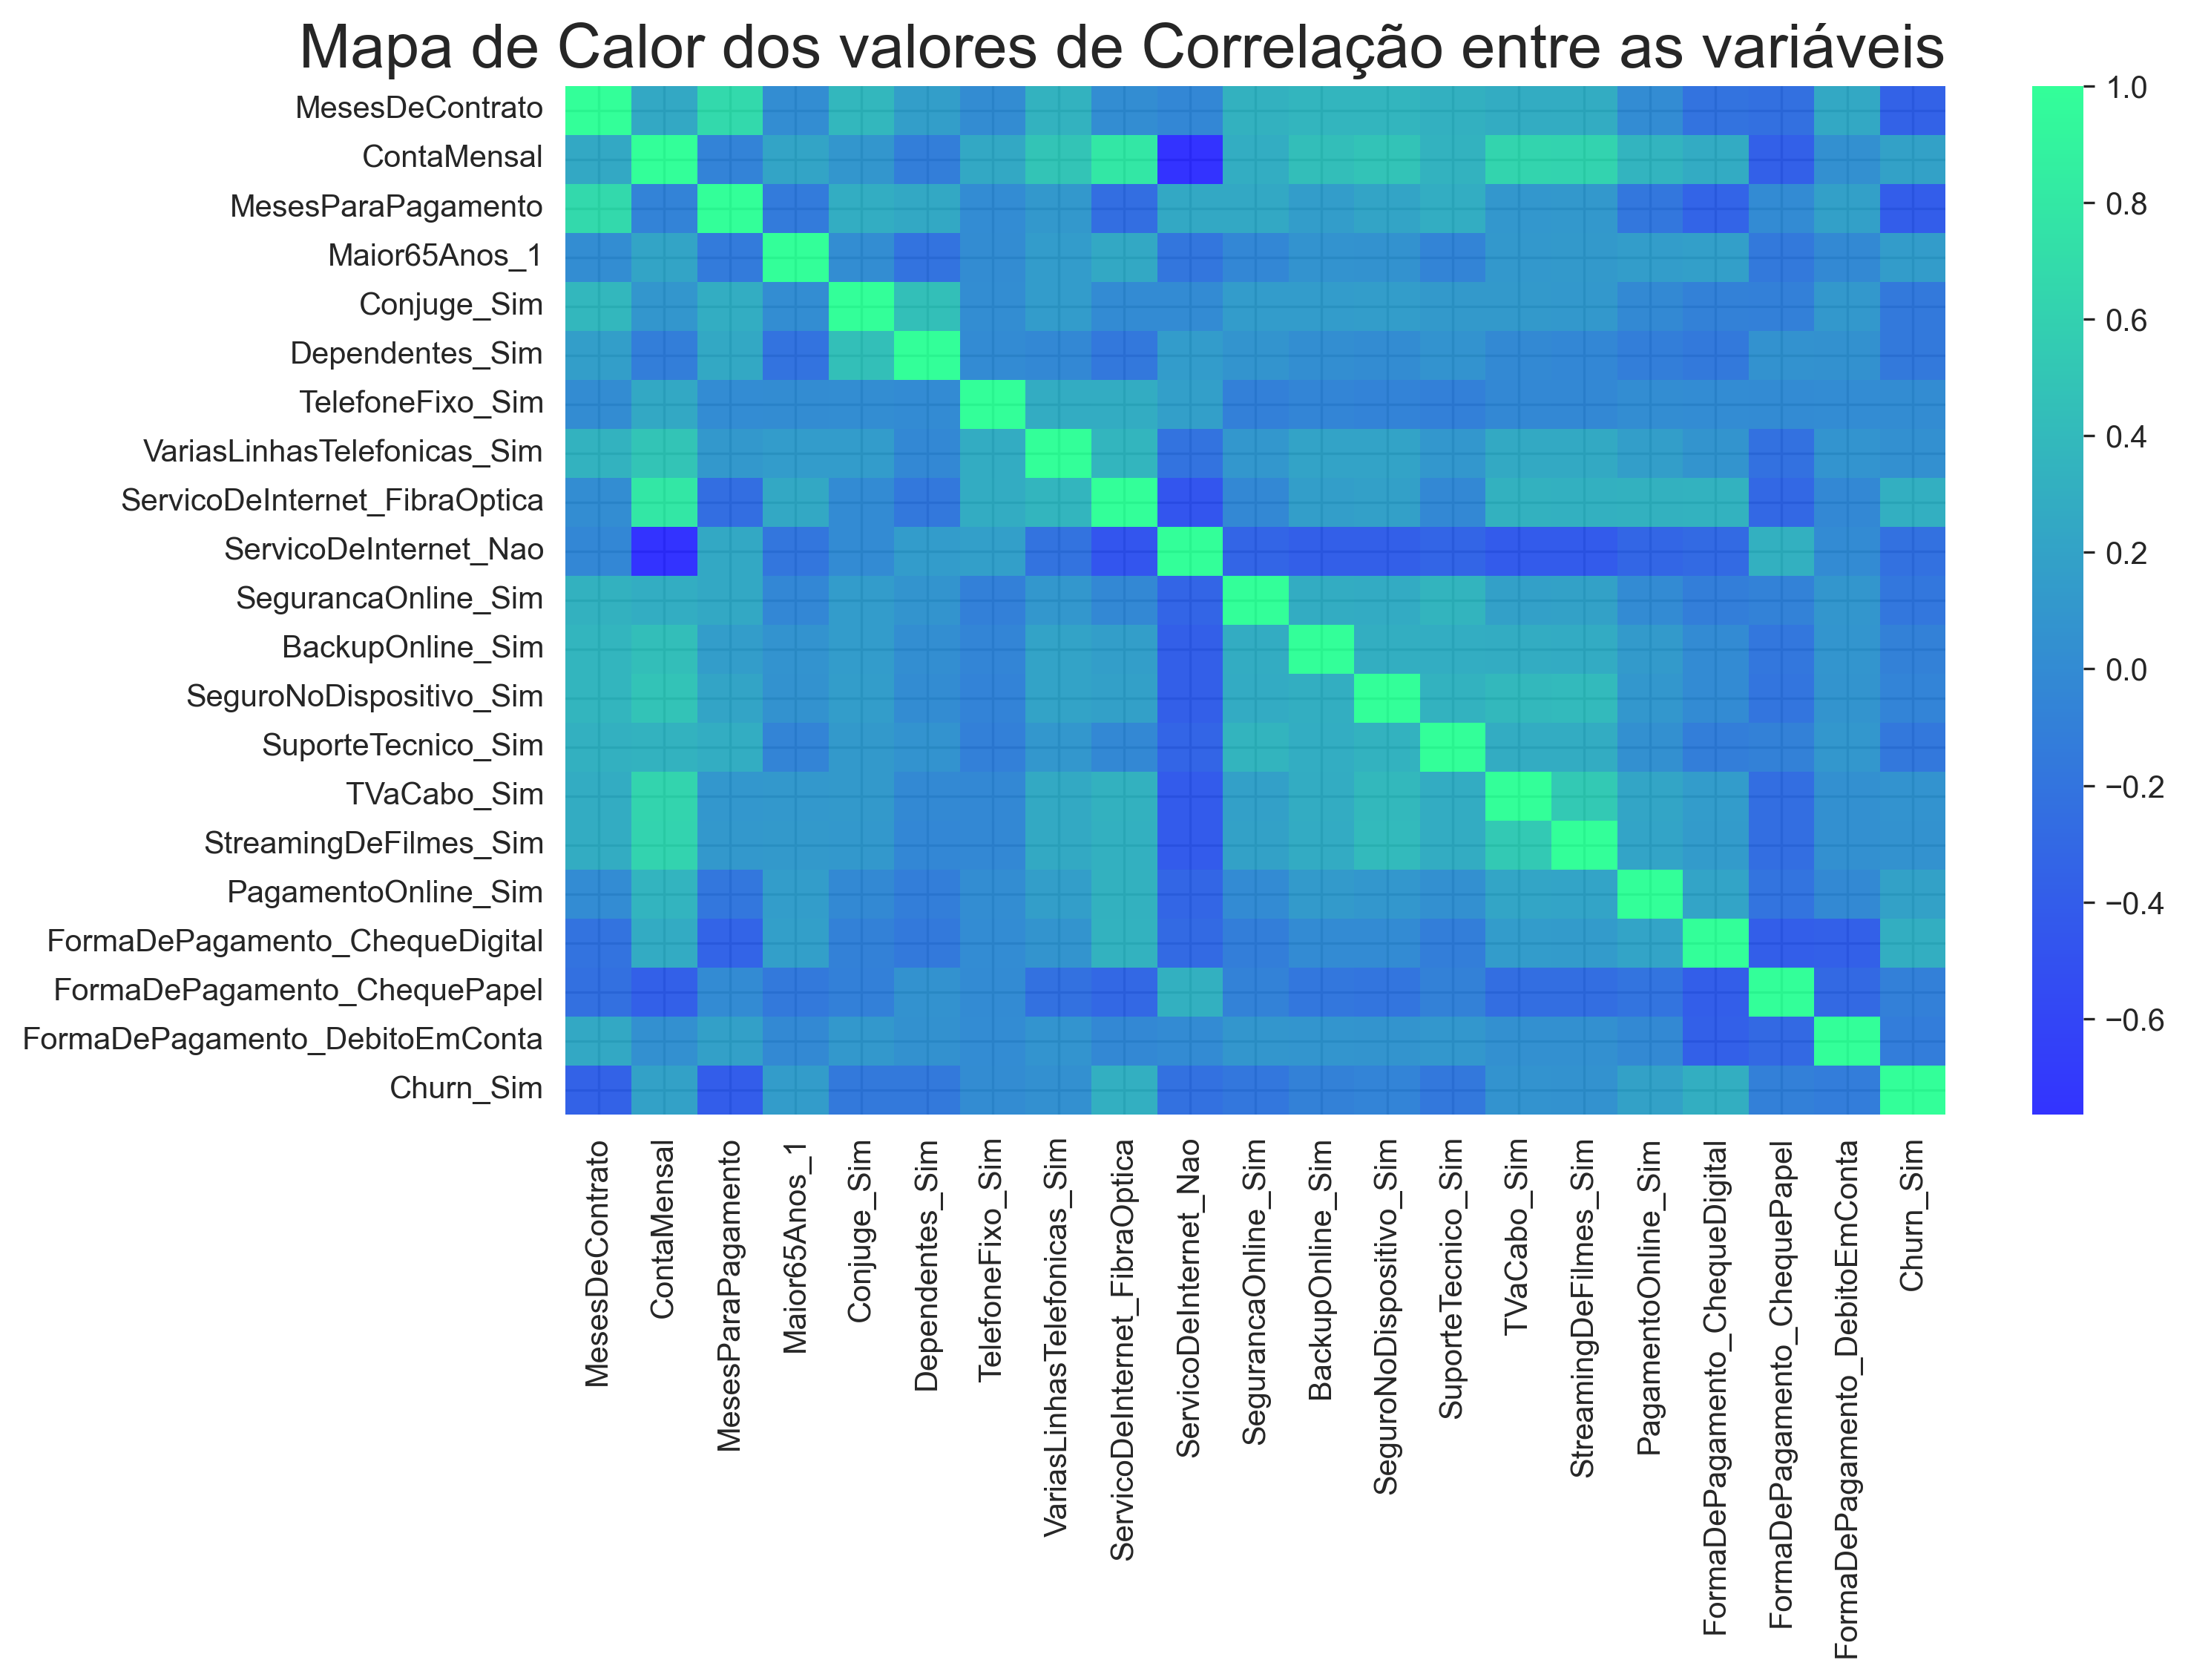

In [354]:
plt.figure(figsize=(10,6), dpi=300)
fig = sns.heatmap(df.corr(),xticklabels=1, yticklabels=1, cmap='winter', alpha=0.8 )
plt.title('Mapa de Calor dos valores de Correlação entre as variáveis',fontdict={'fontsize':20}, loc='right')
plt.savefig('../figs/heatmap.png', bbox_inches='tight', dpi=300)
plt.show()

A pesar de de apresentarem uma correlação fraca +- 0,2, há uma diferença entre o cliente não ter o serviço e ele ter e apenas optar por não assinar o serviço.

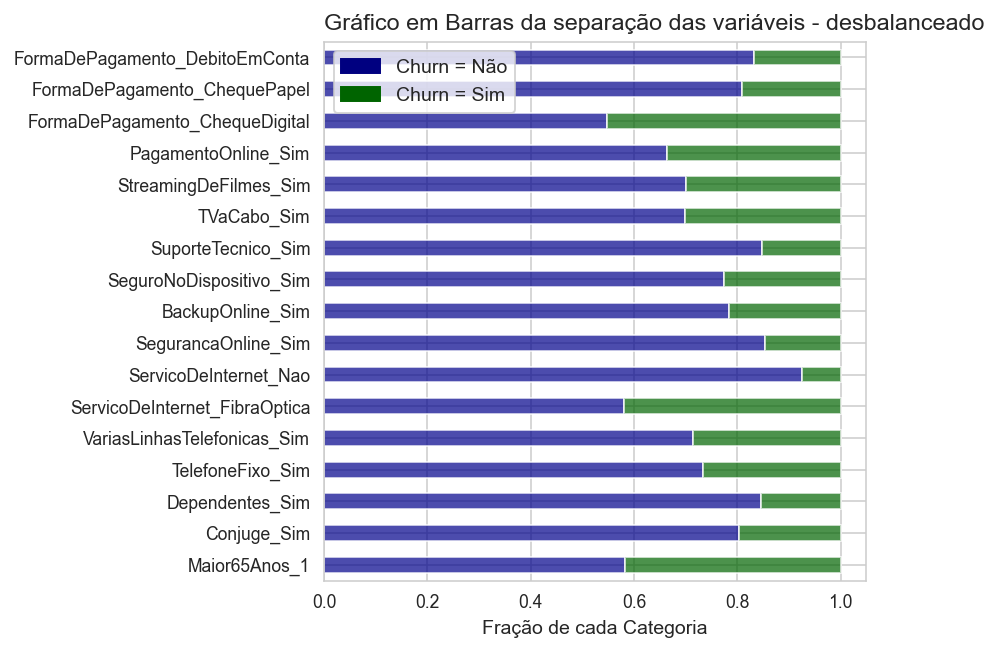

In [355]:
#Plot doas variáveis apenas com sim e não para ver se elas dividem o dataset, DESBALANCEADO

# transforma as variáveis zero e um para o formato unint8
zeroum_to_uint8(df)

# Cria um agrupamento de todas as variáveis categoricas
A = df.select_dtypes(include = 'uint8').groupby(df.Churn_Sim, sort = False).sum()
A = A.div(df.select_dtypes(include = 'uint8').sum(axis=0), axis=1).rename_axis('Cliente_Saiu').T
A = A

plt.rcParams["figure.dpi"] = 140
sns.set_style('whitegrid')
A.columns = ['Não', 'Sim']
A.drop('Churn_Sim').plot(kind="barh", rot=0, stacked=True,figsize=(5,5), 
                         alpha=0.7, color=['darkblue','darkgreen'])
# A.plot()
plt.tick_params(labelsize=9)
plt.xlabel('Fração de cada Categoria')
plt.title('Gráfico em Barras da separação das variáveis - desbalanceado',loc='left')

right_bar = mpatches.Patch(color='navy', label='Churn = Não')
bottom_bar = mpatches.Patch(color='darkgreen', label='Churn = Sim')
plt.legend(handles=[right_bar, bottom_bar])

plt.savefig('../figs/barplot_desbal.png', dpi=300,bbox_inches='tight' )



plt.show()



# Balanceamento de dados

O banco de dados está desbalanceado quanto ao Churn, um balanceamento por oversampling será feito com o RandomSampler

In [356]:
# conferindo o balanceamento da target
df.Churn_Sim.value_counts()

0    5174
1    1869
Name: Churn_Sim, dtype: int64

In [357]:
rands = RandomUnderSampler()
y = df.Churn_Sim
X = df.drop('Churn_Sim', axis=1)
X, y = rands.fit_resample(X, y)

In [358]:
# conferindo a atarget balanceada pelo RandomSampler
y.value_counts()

0    1869
1    1869
Name: Churn_Sim, dtype: int64

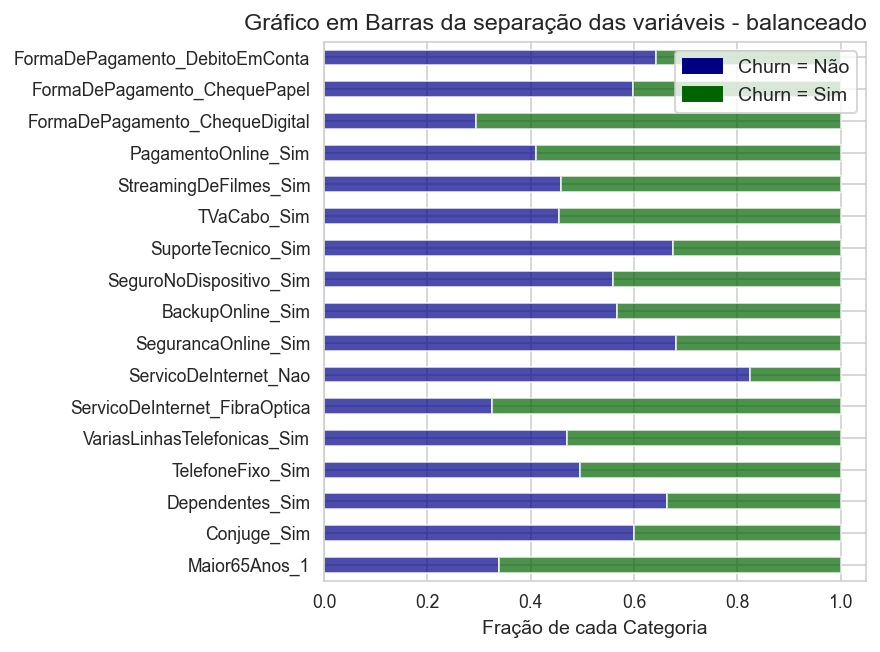

In [359]:
zeroum_to_uint8(X)

# Agrupa os dados binados e os somas de acordo com a categoria, dividindo em seguida para normalizar os valores
A = X.select_dtypes(include = 'uint8').groupby([y], sort = False).sum()
A = A.div(X.select_dtypes(include = 'uint8').sum(axis=0), axis=1)
A = A.T
# Faz o plot dos dados em barras horizontais de forma normalizada para observar a divisão do targuet entre os dados
plt.rcParams["figure.dpi"] = 140
sns.set_style('whitegrid')
A.columns = ['Não', 'Sim']
A.plot(kind="barh", rot=0, stacked=True,
       color=['darkblue','darkgreen'],figsize=(5,5), alpha=0.7)
plt.tick_params(labelsize=9)
plt.xlabel('Fração de cada Categoria')
plt.title('Gráfico em Barras da separação das variáveis - balanceado',loc='right')

right_bar = mpatches.Patch(color='navy', label='Churn = Não')
bottom_bar = mpatches.Patch(color='darkgreen', label='Churn = Sim')
plt.legend(handles=[right_bar, bottom_bar])

plt.savefig('../figs/barplot_bal.png', dpi=300,bbox_inches='tight' )
plt.show()

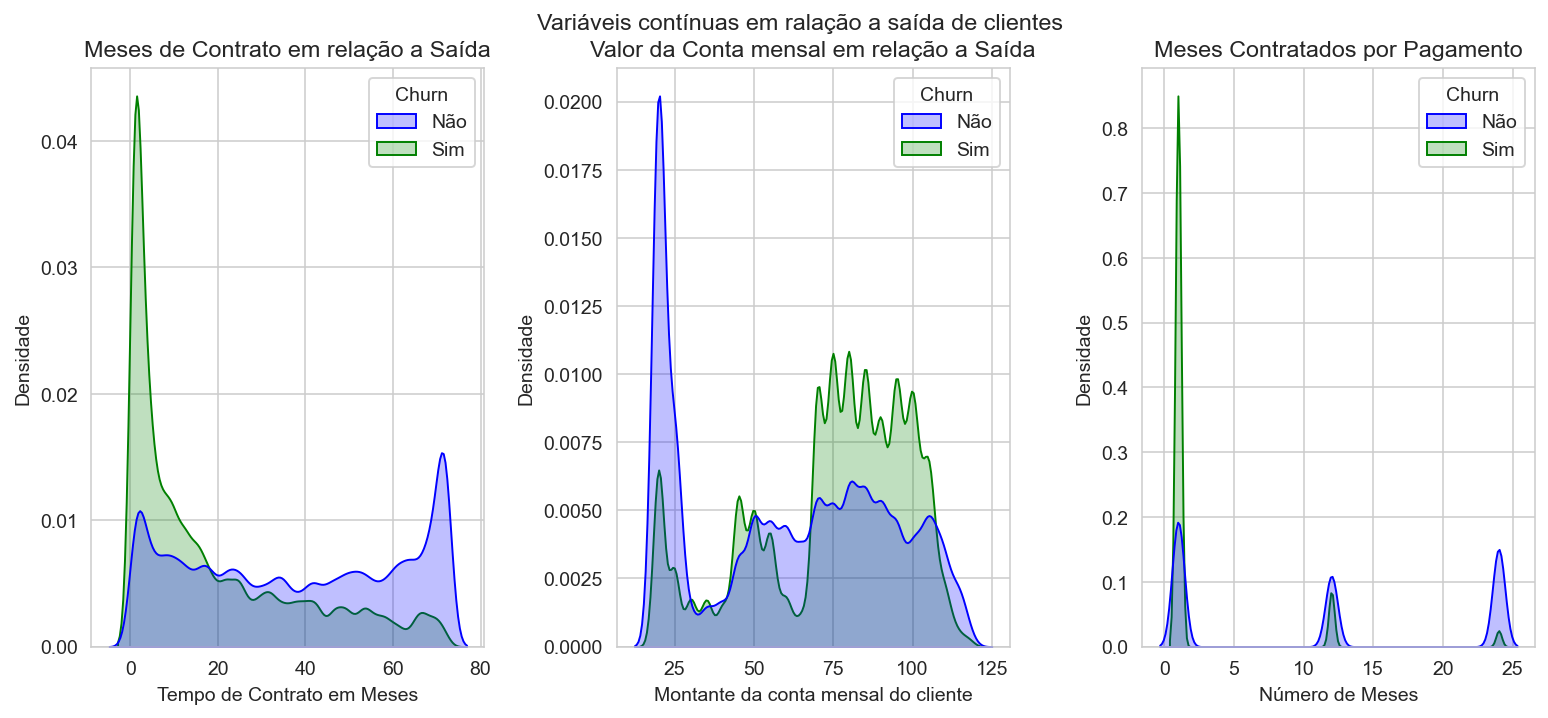

In [360]:
# Criando figura com os dois gráficos de distribuição com ajuste 

tmp = X.copy()
tmp['Churn']=y
tmp['Churn'] = tmp['Churn'].replace([0,1],['Não','Sim'])

#definindo a figura e os subplotes
fig, (ax1, ax2,ax3) = plt.subplots(nrows=1,ncols=3) #uma linha e duas colunas
fig.suptitle('Variáveis contínuas em ralação a saída de clientes')
fig.set_figheight(5)
fig.set_figwidth(11)
fig.tight_layout(w_pad=4)

ax1.set_title('Meses de Contrato em relação a Saída')
sns.kdeplot(ax=ax1,data=tmp,x='MesesDeContrato', hue='Churn', fill=True, palette=['blue','green'],bw_adjust=0.3)
ax1.set_xlabel('Tempo de Contrato em Meses')
ax1.set_ylabel('Densidade')


ax2.set_title('Valor da Conta mensal em relação a Saída')
sns.kdeplot(ax=ax2,data=tmp,x='ContaMensal', hue='Churn', fill=True, palette=['blue','green'],bw_adjust=0.3)
ax2.set_xlabel('Montante da conta mensal do cliente')
ax2.set_ylabel('Densidade')

ax3.set_title('Meses Contratados por Pagamento')
sns.kdeplot(ax=ax3,data=tmp,x='MesesParaPagamento', hue='Churn', fill=True, palette=['blue','green'],bw_adjust=0.2)
ax3.set_xlabel('Número de Meses')
ax3.set_ylabel('Densidade')


plt.savefig('../figs/kdplot_meses_valorconta.png',dpi=300, bbox_inches='tight')
plt.show()

# Comparação entre os modelos

O objetivo da análise é detectar os clientes mais provávei de deixarem a empresa e intervir e oferecer um produto.
Para isso, uma opção é avaliar seria avaliar a precisão, porém o score F1 e a área abaixo da curva ROC são melhores.

In [361]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)


# Definindo a Árvore de decisão com profundidade máxima e com critério 
tree = DecisionTreeClassifier(criterion='entropy', max_depth=6)
tree.fit(X_train,y_train)


lr = LogisticRegression(penalty='l1',solver='saga',C=1, tol=0.000000001)
lr.fit(X_train,y_train)


LogisticRegression(C=1, penalty='l1', solver='saga', tol=1e-09)

In [362]:
print('O score F1 do KNN é:',f1_score(y_test,knn.predict(X_test)))
print('O score F1 do Árvore de Decisão é:',f1_score(y_test,tree.predict(X_test)))
print('O score F1 da Regressão Logistica é:',f1_score(y_test,lr.predict(X_test)))

O score F1 do KNN é: 0.7223974763406941
O score F1 do Árvore de Decisão é: 0.759714512291832
O score F1 da Regressão Logistica é: 0.7646103896103896


In [365]:
print('O score AUC ROC do KNN é:',roc_auc_score(y_test,knn.predict(X_test)))
print('O score AUC ROC do Árvore de Decisão é:',roc_auc_score(y_test,tree.predict(X_test)))
print('O score AUC ROC da Regressão Logistica é:',roc_auc_score(y_test,lr.predict(X_test)))

O score AUC ROC do KNN é: 0.7155553219724343
O score AUC ROC do Árvore de Decisão é: 0.755168245542577
O score AUC ROC da Regressão Logistica é: 0.7652498390466305


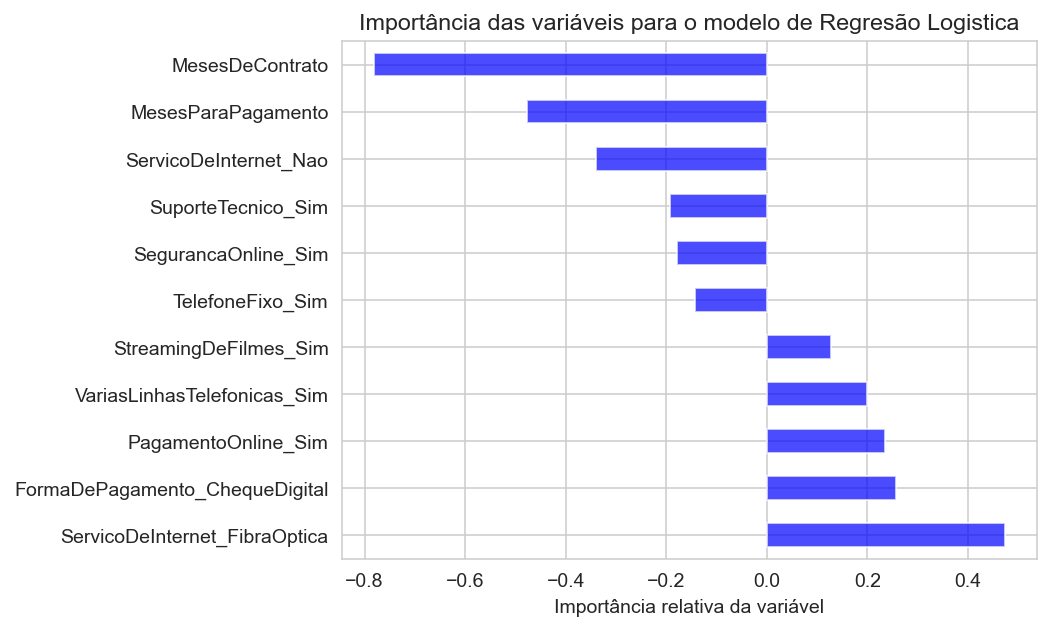

In [366]:
lr = LogisticRegression(penalty='l1',solver='liblinear',C=1, tol=0.000000001)
lr.fit(X_train,y_train)

# Construindo a dataframe com a importância de variáveis da Regressão Logistica
lista_colunas = df.drop('Churn_Sim', axis=1).columns.tolist()
lista_coef_lr = lr.coef_[0].tolist()
df_aux = pd.DataFrame([lista_colunas,lista_coef_lr])
df_aux = df_aux.T.set_index(0).sort_values(by = 1,ascending=False)

#Selecionando os coeficientes mais importantes
df_aux = df_aux.loc[(df_aux[1]>=0.1)|(df_aux[1]<=-0.1)]

# Construindo o Gráfico
df_aux.plot(kind = 'barh',legend = None, cmap='winter', alpha=0.7)
plt.title('Importância das variáveis para o modelo de Regresão Logistica' )
plt.xlabel('Importância relativa da variável')
plt.ylabel(None)
plt.savefig('../figs/var_import_logistica.png', dpi=300,bbox_inches='tight' )
plt.show()

# Inclusão da Pipeline

In [172]:
# Substituindo sim e nao por valores boleanos
df_raw['Churn'] = df_raw.Churn.replace({'Nao':0,'Sim':1})

# separando os dados brutos em Treino e Teste Para não vazar informação nos imputs
df_train, df_test = train_test_split(df_raw, test_size=0.33, random_state=42)

# criando listas de colunas que tenham valores numeticos e objetos
lista_num = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' not in str(df_raw[col].dtype)]
lista_obj = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' in str(df_raw[col].dtype)]

#definindo o encoder para codificar as categorias e o scaler para normalizar as vriáveis numéricas
encoder = OneHotEncoder()
scaler = StandardScaler()

# definindo o tipo de balanceamento que será feito
balancer = SMOTE()

#definindo o modelo
model = lr

# definindo os pacos da pipeline de preprocessamento
steps_num = [('scaler',scaler)]
steps_cat = [('encoder',encoder)]

# Definindo a pipelinde de preprocessamento numerica e categorica
pipe_num = Pipeline(steps_num)
pipe_cat = Pipeline(steps_cat)

# Definindo a pipeline de preprocessamentro completa
pre_process = ColumnTransformer(transformers=[('num', pipe_num,lista_num),('cat',pipe_cat,lista_obj)])


# Definindo os pacos da pipeline
step = [('pre_process',pre_process),('balancer',balancer),('model',model)]

# Definindo a pipeline que teá os passos do step
pipe = Pipeline(step)

# Fazendo o fit nos dados de treino
pipe.fit(df_train,df_train.Churn)

# Fazendo o Predict e já retornando os scores            
score = roc_auc_score(df_test.Churn,pipe.predict(df_test))
score_f1 = f1_score(df_test.Churn,pipe.predict(df_test))
print('A área sobre a curva ROC é {:.4f}'.format(score))
print('O score F1 é {:.4f}'.format(score_f1))



A área sobre a curva ROC é 0.7802
O score F1 é 0.6506


## usando a Pipeline para avaliar diferentes balanceadores e diferentes modelos

In [173]:
# separando os dados brutos em Treino e Teste Para não vazar informação nos imputs
df_train, df_test = train_test_split(df_raw, test_size=0.33, random_state=42)

# criando listas de colunas que tenham valores numeticos e objetos
lista_num = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' not in str(df_raw[col].dtype)]
lista_obj = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' in str(df_raw[col].dtype)]

#definindo o encoder para codificar as categorias e o scaler para normalizar as vriáveis numéricas
encoder = OneHotEncoder()
scaler = StandardScaler()

# definindo o tipo de balanceamento que será feito
balancer = SMOTE()

#definindo o modelo
model = lr

# definindo os pacos da pipeline de preprocessamento
steps_num = [('scaler',scaler)]
steps_cat = [('encoder',encoder)]

# Definindo a pipelinde de preprocessamento numerica e categorica
pipe_num = Pipeline(steps_num)
pipe_cat = Pipeline(steps_cat)

# Definindo a pipeline de preprocessamentro completa
pre_process = ColumnTransformer(transformers=[('num', pipe_num,lista_num),('cat',pipe_cat,lista_obj)])

# Definindo a lista de modelos que serão testados e definindo seus hiperparâmetros
lista_modelo = [KNeighborsClassifier(n_neighbors=8),
                LogisticRegression(penalty='elasticnet', solver='saga',C=0.9, l1_ratio=0.5),
                DecisionTreeClassifier(max_depth=5), 
                RandomForestClassifier(max_depth=5, n_estimators=60),
                GradientBoostingClassifier(n_estimators=30)]

# Definindo a lista de tecnicas de balanceamento de dados a serem testadas
# lista_balancer = [SMOTE(),RandomUnderSampler(),NeighbourhoodCleaningRule(n_neighbors=5)]
lista_balancer = [RandomUnderSampler()]

# Executando um loop que vai passar por diversos modelos e testar os diferentes balanceamentos e cada modelo
for model in lista_modelo:
    for balancer in lista_balancer:
        step = [('pre_process',pre_process),('balancer',balancer),('model',model)]

        pipe = Pipeline(step)
        pipe.fit(df_train,df_train.Churn)
            
        score = roc_auc_score(df_test.Churn,pipe.predict(df_test))
        score_f1 = f1_score(df_test.Churn,pipe.predict(df_test))
        print(model, balancer, 'ROC_AUC Score: {:.4f}'.format(score),'F1 Score: {:.4f}'.format(score_f1))
        print(model, balancer, 'ROC_AUC Score: {:.4f}'.format(roc_auc_score(df_train.Churn,pipe.predict(df_train))),
              'F1 Score: {:.4f}'.format(f1_score(df_train.Churn,pipe.predict(df_train))))
    print('')
        

KNeighborsClassifier(n_neighbors=8) RandomUnderSampler() ROC_AUC Score: 0.7450 F1 Score: 0.6082
KNeighborsClassifier(n_neighbors=8) RandomUnderSampler() ROC_AUC Score: 0.7721 F1 Score: 0.6342

LogisticRegression(C=0.9, l1_ratio=0.5, penalty='elasticnet', solver='saga') RandomUnderSampler() ROC_AUC Score: 0.7793 F1 Score: 0.6462
LogisticRegression(C=0.9, l1_ratio=0.5, penalty='elasticnet', solver='saga') RandomUnderSampler() ROC_AUC Score: 0.7569 F1 Score: 0.6153

DecisionTreeClassifier(max_depth=5) RandomUnderSampler() ROC_AUC Score: 0.7501 F1 Score: 0.6149
DecisionTreeClassifier(max_depth=5) RandomUnderSampler() ROC_AUC Score: 0.7648 F1 Score: 0.6291

RandomForestClassifier(max_depth=5, n_estimators=60) RandomUnderSampler() ROC_AUC Score: 0.7826 F1 Score: 0.6488
RandomForestClassifier(max_depth=5, n_estimators=60) RandomUnderSampler() ROC_AUC Score: 0.7605 F1 Score: 0.6186

GradientBoostingClassifier(n_estimators=30) RandomUnderSampler() ROC_AUC Score: 0.7816 F1 Score: 0.6480
Gradient

## Usando a pipeline para realizar um gridsearch no melhor modelo e no melhor balanceamento

In [174]:
from sklearn.model_selection import GridSearchCV

In [175]:
# Substituindo sim e nao por valores boleanos
df_raw['Churn'] = df_raw.Churn.replace({'Nao':0,'Sim':1})

# separando os dados brutos em Treino e Teste Para não vazar informação nos imputs
df_train, df_test = train_test_split(df_raw, test_size=0.33, random_state=42)

# criando listas de colunas que tenham valores numeticos e objetos
lista_num = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' not in str(df_raw[col].dtype)]
lista_obj = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' in str(df_raw[col].dtype)]

#definindo o encoder para codificar as categorias e o scaler para normalizar as vriáveis numéricas
encoder = OneHotEncoder()
scaler = StandardScaler()

# definindo o tipo de balanceamento que será feito
balancer = SMOTE()

#definindo o modelo
model = GradientBoostingClassifier(n_estimators=30)

# definindo os pacos da pipeline de preprocessamento
steps_num = [('scaler',scaler)]
steps_cat = [('encoder',encoder)]

# Definindo a pipelinde de preprocessamento numerica e categorica
pipe_num = Pipeline(steps_num)
pipe_cat = Pipeline(steps_cat)

# Definindo a pipeline de preprocessamentro completa
pre_process = ColumnTransformer(transformers=[('num', pipe_num,lista_num),('cat',pipe_cat,lista_obj)])


# Definindo os pacos da pipeline
step = [('pre_process',pre_process),('balancer',balancer),('model',model)]

# Definindo a pipeline que teá os passos do step
pipe = Pipeline(step)

# Definindo a lista de parâmetros
param = {'model__n_estimators':[10,50,100,200], 'model__max_depth':[1,2,3,4]}

# Definindo o Gridsearch com score F1
gcv = GridSearchCV(pipe,scoring='f1',n_jobs=-1, param_grid=param)

# Treinando o gridsearch com dados de treino
gcv.fit(df_train,df_train.Churn)

GridSearchCV(estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Maior65Anos',
                                                                          'MesesDeContrato',
                                                                          'ContaMensal',
                                                                          'MesesParaPagamento']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Conjuge',
                                                                          'Dependentes',
                                                                          'TelefoneFixo',
                                                                          'VariasLinhasTelefonicas',
                                                                          'ServicoDeInternet',
                                                                          'SegurancaOnline',
                                                                          'BackupOnline',
                                                                          'SeguroNoDispositivo',
                                                                          'SuporteTecnico',
                                                                          'TVaCabo',
                                                                          'StreamingDeFilmes',
                                                                          'PagamentoOnline',
                                                                          'FormaDePagamento'])])),
                                       ('balancer', SMOTE()),
                                       ('model',
                                        GradientBoostingClassifier(n_estimators=30))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [1, 2, 3, 4],
                         'model__n_estimators': [10, 50, 100, 200]},
             scoring='f1')

In [176]:
# Retornando a melhor combinanção dos parâmetros avaliados
print('A melhor profundidade foi de ',gcv.best_params_['model__max_depth'])
print('O melhor numero de estimadores foi de ',gcv.best_params_['model__n_estimators'])

# definindo o melhor modelo
melhor_modelo = gcv.best_estimator_

# avaliando o melhor modelo
print('O score F1 dos dados totais de treino é {:.4f}'.format(f1_score(df_train.Churn,melhor_modelo.predict(df_train))))
print('O score F1 dos dados de teste é {:.4f}'.format(f1_score(df_test.Churn,melhor_modelo.predict(df_test))))


A melhor profundidade foi de  3
O melhor numero de estimadores foi de  50
O score F1 dos dados totais de treino é 0.6408
O score F1 dos dados de teste é 0.6555


In [261]:
roc_auc_score(roc_auc_score(df_test.Churn,melhor_modelo.predict(df_test)))

0.7790490149345605

In [262]:
roc_auc_score(df_train.Churn,melhor_modelo.predict(df_train))

0.7690019854195533

In [263]:
f1_score(df_test.Churn,melhor_modelo.predict(df_test))

0.6555183946488295

In [264]:
f1_score(df_train.Churn,melhor_modelo.predict(df_train))

0.6408036023553862

## Usando SHAP para retornar a importância das variáveis na previsão

In [177]:
import shap

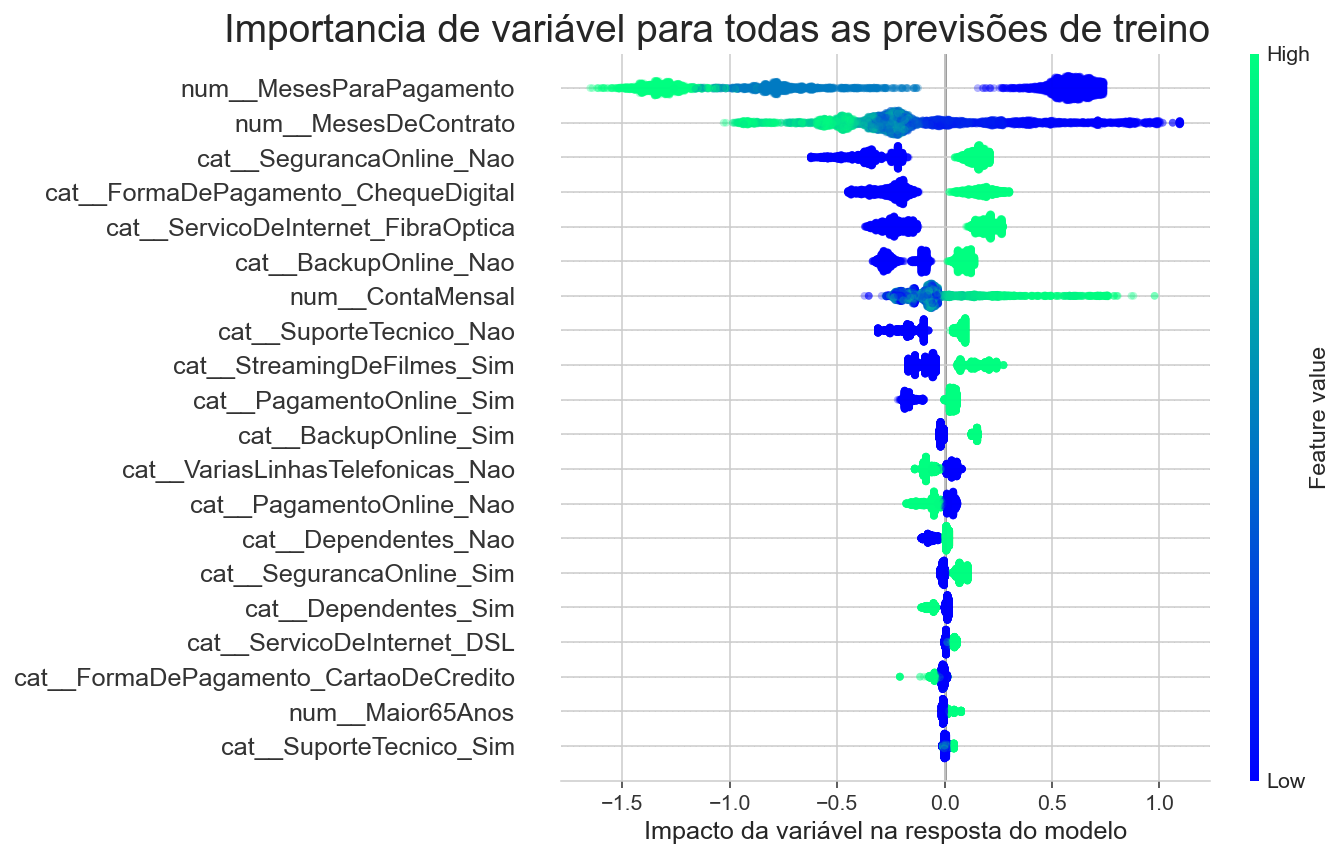

In [183]:
# definindo o modelo de explicação do tipo gradient boost de arvores
explainer = shap.TreeExplainer(melhor_modelo['model'])

# separando os dados brutos em Treino e Teste Para não vazar informação nos imputs
df_train, df_test = train_test_split(df_raw, test_size=0.33, random_state=42)

# separando X e y dos dados de treino e aplicando o preprocessamento da pipeline em X
X = melhor_modelo['pre_process'].transform(df_train)
y = df_train.Churn

# retornando os valores shap do explicador
shap_values = explainer.shap_values(X,y)

# Definindo o nome das variaveis e retornando um gráfico violino das previsões em função do Churn
feature_names=melhor_modelo['pre_process'].get_feature_names_out()
fig, ax = plt.subplots()
fig = shap.summary_plot(
    shap_values, 
    X, 
    feature_names = feature_names,
    plot_type='dot',
    plot_size=(10,6),
    show=False,
    cmap = "winter",
    alpha=0.3)
plt.title('Importancia de variável para todas as previsões de treino', loc='right',fontdict={'fontsize':20})
plt.xlabel('Impacto da variável na resposta do modelo')
plt.savefig('../figs/vai_imp_gradient.png', dpi=300,bbox_inches='tight' )
plt.show(fig)




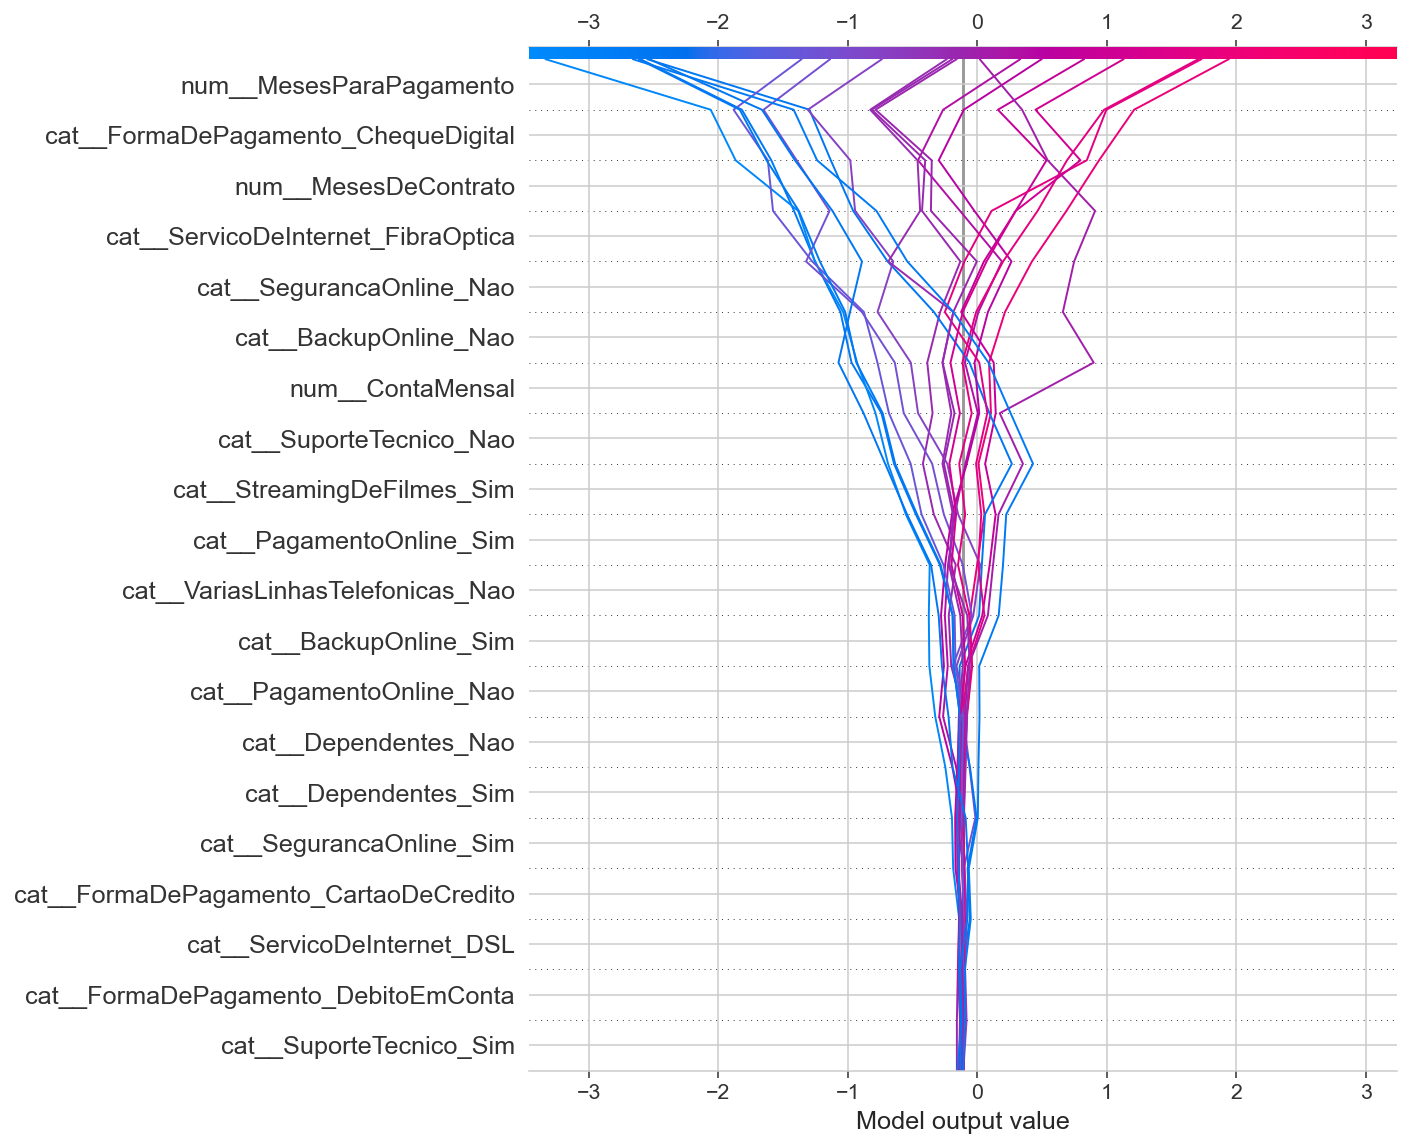

In [195]:
shap.decision_plot(explainer.expected_value, shap_values[:20],feature_names=feature_names, ignore_warnings=True)

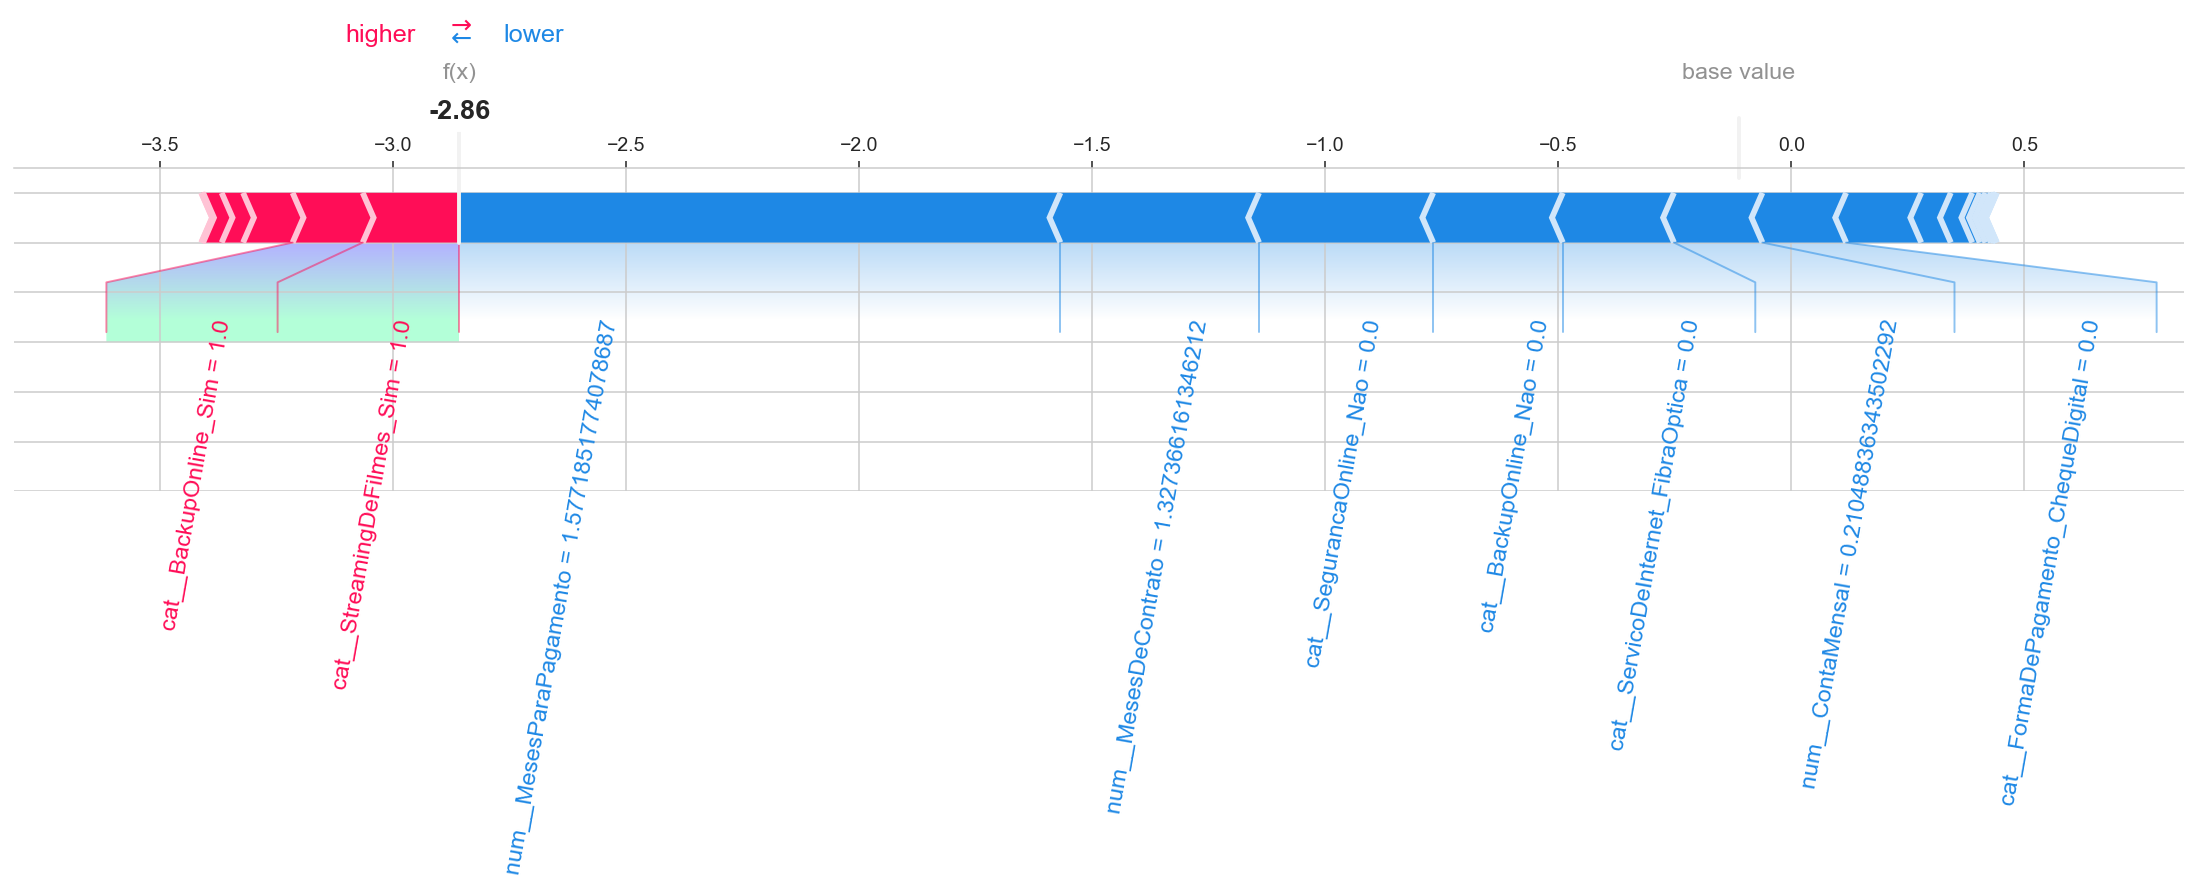

In [180]:
amostra = 500

fig = shap.force_plot(
    explainer.expected_value, 
    shap_values[amostra,:], 
    X[amostra,:], 
    matplotlib=True, 
    feature_names=melhor_modelo['pre_process'].get_feature_names_out(), 
    text_rotation=80, show=False, plot_cmap='winter')
plt.set_cmap('winter')
plt.show(fig)

In [229]:
df_proba = df_raw.copy()
df_proba['proba'] = melhor_modelo.predict_proba(df_raw)[:,1]
df_proba.loc[df_raw.Churn==0].sort_values('proba',ascending=False)

,Maior65Anos,Conjuge,Dependentes,MesesDeContrato,TelefoneFixo,VariasLinhasTelefonicas,ServicoDeInternet,SegurancaOnline,BackupOnline,SeguroNoDispositivo,SuporteTecnico,TVaCabo,StreamingDeFilmes,PagamentoOnline,FormaDePagamento,ContaMensal,Churn,MesesParaPagamento,proba
5474,0,Nao,Nao,1,Sim,Sim,FibraOptica,Nao,Nao,Nao,Nao,Sim,Nao,Sim,ChequeDigital,84.60,0,1,0.887446
459,0,Nao,Nao,1,Sim,Sim,FibraOptica,Nao,Nao,Nao,Nao,Nao,Nao,Sim,ChequeDigital,75.10,0,1,0.887446
5140,0,Nao,Nao,1,Sim,Nao,FibraOptica,Nao,Nao,Nao,Nao,Sim,Sim,Sim,ChequeDigital,89.25,0,1,0.883173
4039,0,Nao,Nao,7,Sim,Sim,FibraOptica,Nao,Nao,Nao,Nao,Sim,Sim,Sim,ChequeDigital,94.10,0,1,0.881628
3159,1,Nao,Nao,3,Sim,Sim,FibraOptica,Nao,Nao,Nao,Nao,Sim,Sim,Sim,ChequeDigital,94.85,0,1,0.881628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805,0,Sim,Sim,72,Sim,Sim,DSL,Sim,Sim,Sim,Nao,Nao,Nao,Nao,CartaoDeCredito,64.45,0,24,0.033013
3982,0,Nao,Sim,71,Sim,Sim,Nao,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,Nao,ChequePapel,24.35,0,24,0.032749
1514,0,Nao,Sim,63,Sim,Nao,Nao,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,Nao,CartaoDeCredito,19.50,0,24,0.032382
872,0,Nao,Sim,66,Sim,Nao,Nao,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,SemServicoDeInternet,Nao,CartaoDeCredito,19.95,0,24,0.032382
